In [9]:
import pandas as pd

In [17]:
def process_raw_data(path, target, date):
    print("Preprocessing data: it will take around 15s")
    df = pd.read_csv(path)
    df[date] = pd.to_datetime(df[date])

    # Fill out missing dates
    df_new = pd.DataFrame()
    df_new[date] = pd.date_range(
        start=df[date].iloc[0],
        end=df[date].iloc[-1],
        freq="15min",
        inclusive="both",
    )
    df_new = pd.merge(df_new, df, on=date, how="outer")
    df = df_new.copy()
    df[date] = pd.to_datetime(df[date], errors="coerce")

    # Prepare columns for data filling
    df["month"] = df[date].dt.month
    df["dow"] = df[date].dt.dayofweek
    df["hour"] = df[date].dt.hour
    df["minute"] = df[date].dt.minute
    keys = ["month", "dow", "hour", "minute"]

    # Select most frequent value for month, day of the week, hour and minute and save it to column
    modes = (
        df.dropna(subset=[target])
        .groupby(keys, observed=True)[target]
        .agg(lambda s: s.value_counts().idxmax())
        .rename("value_mode")
        .reset_index()
    )
    out = df.merge(modes, on=keys, how="left")

    # Fill out missing values with most frequent value for month, day of the week, hour and minute
    out[target] = out[target].fillna(out["value_mode"])
    df = out.drop(columns=keys + ["value_mode"])

    # Aggregate to daily level
    daily = df.resample("D", on=date)[target].sum().reset_index()

    # Round and rename columns
    daily[target] = daily[target].round(4)
    daily.rename(columns={date: "datetime", target: "y"}, inplace=True)

    daily.to_csv(path, index=False)

In [18]:
for i in range(1, 322):
    process_raw_data(f"T{i}.csv", "y", "datetime")

Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take around 15s
Preprocessing data: it will take

KeyboardInterrupt: 

In [1]:
from sktime.datasets import load_forecastingdata

df, meta = load_forecastingdata(
    name="electricity_hourly_dataset",            # example dataset name
    value_column_name="y",
    return_type="default_tsf",
)


In [2]:
df

,series_name,start_timestamp,y
0,T1,2012-01-01 00:00:01,"[14.0, 18.0, 21.0, 20.0, 22.0, 20.0, 20.0, 20...."
1,T2,2012-01-01 00:00:01,"[69.0, 92.0, 96.0, 92.0, 91.0, 92.0, 91.0, 92...."
2,T3,2012-01-01 00:00:01,"[234.0, 312.0, 312.0, 312.0, 312.0, 187.0, 138..."
3,T4,2012-01-01 00:00:01,"[415.0, 556.0, 560.0, 443.0, 346.0, 340.0, 376..."
4,T5,2012-01-01 00:00:01,"[215.0, 292.0, 272.0, 213.0, 190.0, 178.0, 199..."
...,...,...,...
316,T317,2012-01-01 00:00:01,"[48.0, 65.0, 64.0, 65.0, 75.0, 64.0, 65.0, 69...."
317,T318,2012-01-01 00:00:01,"[38.0, 47.0, 43.0, 39.0, 40.0, 39.0, 49.0, 55...."
318,T319,2012-01-01 00:00:01,"[1558.0, 2177.0, 2193.0, 1315.0, 1378.0, 1250...."
319,T320,2012-01-01 00:00:01,"[182.0, 253.0, 218.0, 195.0, 191.0, 185.0, 191..."


In [8]:
import pandas as pd

for _, r in df.iterrows():
    y = r["y"]
    series_name = r["series_name"]
    start = pd.to_datetime(r["start_timestamp"]).floor("15min")
    idx = pd.date_range(start, periods=len(y), freq="15min")

    df_15m = pd.DataFrame({"datetime": idx, "y": y})
    df_15m.to_csv(f"./{series_name}.csv", index=False)


In [12]:
df_15m[df_15m["series_name"] == "T1"]

,series_name,datetime,y
0,T1,2012-01-01 00:00:00,14.0
1,T1,2012-01-01 00:15:00,18.0
2,T1,2012-01-01 00:30:00,21.0
3,T1,2012-01-01 00:45:00,20.0
4,T1,2012-01-01 01:00:00,22.0
...,...,...,...
26299,T1,2012-09-30 22:45:00,11.0
26300,T1,2012-09-30 23:00:00,11.0
26301,T1,2012-09-30 23:15:00,12.0
26302,T1,2012-09-30 23:30:00,10.0


In [6]:
import numpy as np
import pandas as pd

start = "1969-01-01"
end = "1988-12-31"

idx = pd.date_range("2011-01-01 00:00:00", periods=len(df), freq="15min")

df = pd.DataFrame(
    {
        "y": df.iloc[0]["y"],
    },
    index=idx,
)

df.index.name = "date"
df.reset_index(inplace=True)  # optional: keep date as a column

df


ValueError: Length of values (26304) does not match length of index (321)

In [52]:
df.to_csv("../../data/us.csv", index=False)

C:\Users\janav\Documents\projects\iterative-long-term-forecasting\src\utils\plots.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


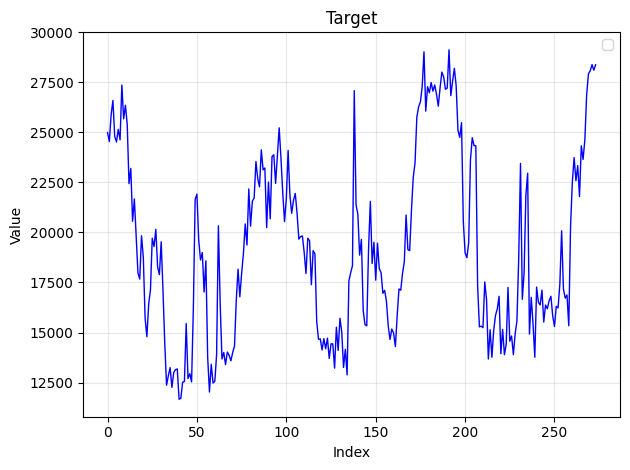

In [23]:
from src.utils.plots import plot_target

plot_target("T5.csv", "y")